In [45]:
from torch import nn
import torch
from torch import optim
import numpy as np
import matplotlib.pyplot as plt

In [46]:
import pandas as pd 
ds = pd.read_excel("data.xlsx",engine="openpyxl")
ds.head()

,Tarih,Kapanış,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9
0,5 Kasım 2019,274.62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,6 Kasım 2019,275.67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,7 Kasım 2019,271.28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,8 Kasım 2019,270.33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,11 Kasım 2019,270.13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
# Gerekli kütüphaneleri içe aktarıyoruz. 
# nn modülü, sinir ağı katmanlarını (RNN, Linear vb.) ve modüllerini içerir.
import torch.nn as nn

# 'Rnn' adında yeni bir sınıf tanımlıyoruz. 
# Bu sınıf, PyTorch'un temel sinir ağı modülü olan 'nn.Module' sınıfından miras alır.
# Bu sayede kendi modelimizi PyTorch'un altyapısıyla uyumlu hale getirmiş oluruz.
class Rnn(nn.Module):
    # Modelin yapısını ve katmanlarını başlatan kurucu metot (initializer/constructor).
    # Bu metot, model ilk oluşturulduğunda bir kez çalışır.
    # input_size: Her bir zaman adımındaki girdi özelliğinin boyutu (örneğin, kelime vektörünün boyutu).
    # hidden_size: RNN'in gizli katmanındaki nöron sayısı. Bu, ağın "hafızasının" boyutunu belirler.
    # num_layers: Üst üste gelecek RNN katmanı sayısı. Derin bir RNN oluşturmak için kullanılır. Varsayılan değeri 1'dir.
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        # Miras aldığımız nn.Module sınıfının kurucu metodunu çağırıyoruz. Bu satır her zaman gereklidir.
        super(Rnn, self).__init__()
        # RNN katmanını tanımlıyoruz.
        # input_size: Girdi verisinin özellik boyutu.
        # hidden_size: Gizli durumun (hidden state) boyutu.
        # num_layers: Üst üste yığılmış RNN katmanlarının sayısı.
        # batch_first=True: Girdi ve çıktı tensörlerinin boyut sıralamasını (batch_boyutu, dizi_uzunluğu, özellik_sayısı) şeklinde ayarlar.
        # Bu, veriyi daha sezgisel bir şekilde işlememizi sağlar.
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        
        # Tam bağlantılı (Fully Connected) katmanı tanımlıyoruz. Bu katman genellikle RNN'in çıktısını alıp
        # istenen sonuca (örneğin, bir sınıflandırma tahmini) dönüştürmek için kullanılır.
        # hidden_size: Girdi boyutu olarak RNN'in gizli katman boyutunu alır.
        # output_size: Modelin üreteceği nihai çıktının boyutu (örneğin, sınıf sayısı).
        self.fc = nn.Linear(hidden_size, output_size)

    # Modelin ileri geçiş (forward pass) fonksiyonu. Verinin model içinden nasıl akacağını tanımlar.
    # x: Modele verilecek girdi verisi. Boyutu (batch_boyutu, dizi_uzunluğu, input_size) olmalıdır.
    def forward(self, x):
        # Girdi verisini (x) RNN katmanından geçiriyoruz.
        # self.rnn(x) iki değer döndürür:
        # 1. out: Her zaman adımındaki RNN çıktısını içeren bir tensör. Boyutu: (batch_boyutu, dizi_uzunluğu, hidden_size).
        # 2. h_n (burada '_' ile atlandı): Son zaman adımındaki gizli durumu (hidden state) içeren bir tensör. Genellikle bir sonraki adıma bilgi taşımak için kullanılır ama bu kodda kullanılmıyor.
        out, _ = self.rnn(x)
        
        # RNN çıktısının sadece son zaman adımını alıp tam bağlantılı katmana veriyoruz.
        # out[:, -1, :] ifadesi:
        # ':' -> Batch'teki tüm örnekleri al.
        # -1 -> Dizi uzunluğu boyutunun son elemanını (yani son zaman adımının çıktısını) al.
        # ':' -> O zaman adımındaki tüm gizli durum özelliklerini al.
        # Bu işlem, genellikle dizi tabanlı bir görevin sonunda tek bir karar vermek için kullanılır (örn: metin sınıflandırma).
        out = self.fc(out[:, -1, :])
        
        # Tam bağlantılı katmandan geçen ve son tahminleri içeren 'out' tensörünü döndürüyoruz.
        return out


In [48]:
# Hiperparametreler (Hyperparameters)
seq_length = 1000      # input dizisinin boyutu
input_size =  1     # input dizisinin boyutu (özellik sayısı)
hidden_size = 128     # rnn'in gizli katmanındaki düğüm sayısı
output_size = 1      # output boyutu ya da tahmin edilen değer
num_layers = 2      # rnn katman sayısı
epochs = 20          # modelin kaç kez tüm veri seti üzerinde eğitileceği
batch_size = 32      # her bir eğitim adımında kaç örneğin kullanılacağı
learning_rate = 0.001 # optimizasyon algoritması için öğrenme oranı ya da hızı

In [49]:

from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler# --- VERİ ENTEGRASYON ADIMLARI ---

# Adım 1: Veri Yükleme ve Temizleme
# 'Kapanış' sütunundaki verileri alıyoruz.
try:
    ds = pd.read_excel("data.xlsx", engine="openpyxl")
    # Sadece 'Kapanış' sütununu alıp bir NumPy dizisine çeviriyoruz.
    closing_prices = ds['Kapanış'].values.astype(float)
except FileNotFoundError:
    print("Hata: 'data.xlsx' dosyası bulunamadı. Lütfen dosyanın doğru yolda olduğundan emin olun.")
    exit()


# Adım 2: Veriyi Ölçeklendirme (Normalization)
# Veriyi 0 ile 1 arasına sıkıştırarak modelin daha iyi eğitilmesini sağlıyoruz.
scaler = MinMaxScaler(feature_range=(0, 1))
# scaler'ı veriye göre eğitiyor ve aynı anda veriyi dönüştürüyoruz.
# reshape(-1, 1) işlemi, veriyi scaler'ın beklediği 2D formata getirir.
closing_prices_scaled = scaler.fit_transform(closing_prices.reshape(-1, 1))


# Adım 3: Dizileri (Sequences) Oluşturma
# Bu fonksiyon, zaman serisi verisini RNN'in anlayacağı (girdi, hedef) çiftlerine dönüştürür.
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        # 'seq_length' kadar veri al (örneğin 50 gün) -> Bu bizim GİRDİMİZ (X)
        seq = data[i:i+seq_length]
        # Bir sonraki veriyi al (örneğin 51. gün) -> Bu bizim HEDEFİMİZ (y)
        label = data[i+seq_length]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

# Ölçeklenmiş veriden dizileri ve etiketleri oluşturuyoruz.
X, y = create_sequences(closing_prices_scaled, seq_length)


# Adım 4: Veriyi Eğitim ve Test Olarak Ayırma
# Zaman serisi verilerinde ayırma işlemi rastgele yapılmaz. Verinin başı eğitim, sonu test için kullanılır.
# Verinin %80'ini eğitim, %20'sini test için ayıralım.
train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"Eğitim seti boyutu: {len(X_train)} dizi")
print(f"Test seti boyutu: {len(X_test)} dizi")


# Adım 5: PyTorch Tensörlerine Dönüştürme
# NumPy dizilerini PyTorch tensörlerine çeviriyoruz.
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

# Tensörlerin boyutlarını kontrol edelim
# X_train boyutu -> (örnek_sayısı, dizi_uzunluğu, özellik_sayısı) yani (num_samples, 50, 1)
# y_train boyutu -> (örnek_sayısı, özellik_sayısı) yani (num_samples, 1)
print(f"X_train tensör boyutu: {X_train.shape}")
print(f"y_train tensör boyutu: {y_train.shape}")


# Adım 6: DataLoader Oluşturma
# Tensörleri bir veri setinde birleştirip DataLoader'a yüklüyoruz.
# Bu yapı, eğitim sırasında veriyi batch'ler halinde modele beslemeyi kolaylaştırır.
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True) # Eğitimde karıştırmak genellikle iyidir

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False) # Testte karıştırma yapılmaz

# VERİ HAZIR!
# Artık 'train_loader' ve 'test_loader'ı kullanarak modelinizi eğitebilirsiniz.

print("\nVeri başarıyla yüklendi, işlendi ve modele hazır hale getirildi.")
print("Artık 'train_loader'ı kullanarak eğitim döngüsünü başlatabilirsiniz.")

# Örnek bir batch'in boyutlarını görelim:
dataiter = iter(train_loader)
sample_x, sample_y = next(dataiter)

print(f"\nDataLoader'dan gelen bir batch'in girdi boyutu (X): {sample_x.shape}")
print(f"DataLoader'dan gelen bir batch'in etiket boyutu (y): {sample_y.shape}")


Eğitim seti boyutu: 365 dizi
Test seti boyutu: 92 dizi
X_train tensör boyutu: torch.Size([365, 1000, 1])
y_train tensör boyutu: torch.Size([365, 1])

Veri başarıyla yüklendi, işlendi ve modele hazır hale getirildi.
Artık 'train_loader'ı kullanarak eğitim döngüsünü başlatabilirsiniz.

DataLoader'dan gelen bir batch'in girdi boyutu (X): torch.Size([32, 1000, 1])
DataLoader'dan gelen bir batch'in etiket boyutu (y): torch.Size([32, 1])


In [50]:
# --- Model, Kayıp Fonksiyonu ve Optimizörün Tanımlanması ---

# Daha önce tanımladığımız Rnn sınıfından bir nesne oluşturarak modelimizi yaratıyoruz.
# Hiperparametreleri (girdi boyutu, gizli katman boyutu vb.) kullanarak modelin yapısını belirliyoruz.
model = Rnn(input_size, hidden_size, output_size, num_layers)

# Kayıp (Loss) fonksiyonunu tanımlıyoruz. 
# nn.MSELoss (Mean Square Error - Ortalama Kare Hatası), regresyon problemlerinde (sayısal bir değer tahmini) yaygın olarak kullanılır.
# Modelin tahminleri ile gerçek değerler arasındaki farkların karesinin ortalamasını hesaplar.
criterion = nn.MSELoss()

# Optimizasyon algoritmasını belirliyoruz.
# torch.optim.Adam, modelin ağırlıklarını (parametrelerini) nasıl güncelleyeceğini belirleyen bir algoritmadır.
# Amacı, kayıp (loss) değerini düşürecek şekilde ağırlıkları ayarlamaktır.
# model.parameters(), optimizörün hangi ağırlıkları güncelleyeceğini belirtir.
# lr=learning_rate, ağırlıkların ne kadar büyük adımlarla güncelleneceğini belirleyen öğrenme oranıdır.
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


# --- Eğitim Döngüsü ---

print("Eğitim başlıyor...")
# Modelin tüm veri seti üzerinden kaç kez geçeceğini belirleyen ana döngü.
# Bir epoch, tüm eğitim verisinin bir kez baştan sona işlenmesi demektir.
for epoch in range(epochs):
    
    # DataLoader'dan verileri yığınlar (batch) halinde çeken iç döngü.
    # Her döngü adımında 'batch_size' kadar (örneğin 32) girdi (batch_x) ve etiket (batch_y) alınır.
    # Görseldeki 'dataloader' yerine daha önce tanımladığımız 'train_loader' kullanılıyor.
    for batch_x, batch_y in train_loader: 
        
        # 1. Gradyanları Sıfırlama
        # Her yeni batch için gradyanları yeniden hesaplamadan önce bir önceki adımdan kalanları temizliyoruz.
        # Bu yapılmazsa, gradyanlar her adımda birikerek hatalı güncellemelere yol açar.
        optimizer.zero_grad()
        
        # 2. İleri Yayılım (Forward Pass)
        # Girdi verisini (batch_x) modele vererek bir tahmin (pred_y) üretmesini sağlıyoruz.
        pred_y = model(batch_x)
        
        # 3. Kaybı Hesaplama
        # Modelin tahminleri (pred_y) ile gerçek değerleri (batch_y) karşılaştırarak aradaki hatayı (loss) hesaplıyoruz.
        loss = criterion(pred_y, batch_y)
        
        # 4. Geri Yayılım (Backward Pass)
        # Hesaplanan kaybın (loss), modelin öğrenilebilir her bir ağırlığına göre gradyanını (türevini) hesaplıyoruz.
        # Bu gradyanlar, her bir ağırlığın hataya olan etkisini gösterir.
        loss.backward()
        
        # 5. Ağırlıkları Güncelleme
        # Optimizör, hesaplanan gradyanları kullanarak modelin ağırlıklarını günceller.
        # Bu güncelleme, kaybı azaltacak yönde yapılır.
        optimizer.step()
        
    # Her epoch'un sonunda o anki kayıp (loss) değerini ekrana yazdırıyoruz.
    # Bu, eğitimin ilerleyişini takip etmemizi sağlar.
    # loss.item(), tek bir sayı içeren tensörden Python'un anladığı sayı değerini alır.
    # ':.4f' ise sayıyı virgülden sonra 4 basamak olacak şekilde formatlar.
    if (epoch+1) % 5 == 0 or epoch == 0: # Her 5 epoch'ta bir ve ilk epoch'ta durumu yazdır
        print(f"Epoch: [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

print("Eğitim tamamlandı.")

Eğitim başlıyor...
Epoch: [1/20], Loss: 0.0217
Epoch: [5/20], Loss: 0.0003
Epoch: [10/20], Loss: 0.0000
Epoch: [15/20], Loss: 0.0002
Epoch: [20/20], Loss: 0.0001
Eğitim tamamlandı.



Test Verisi Üzerindeki Kök Ortalama Kare Hatası (RMSE): 32.1980


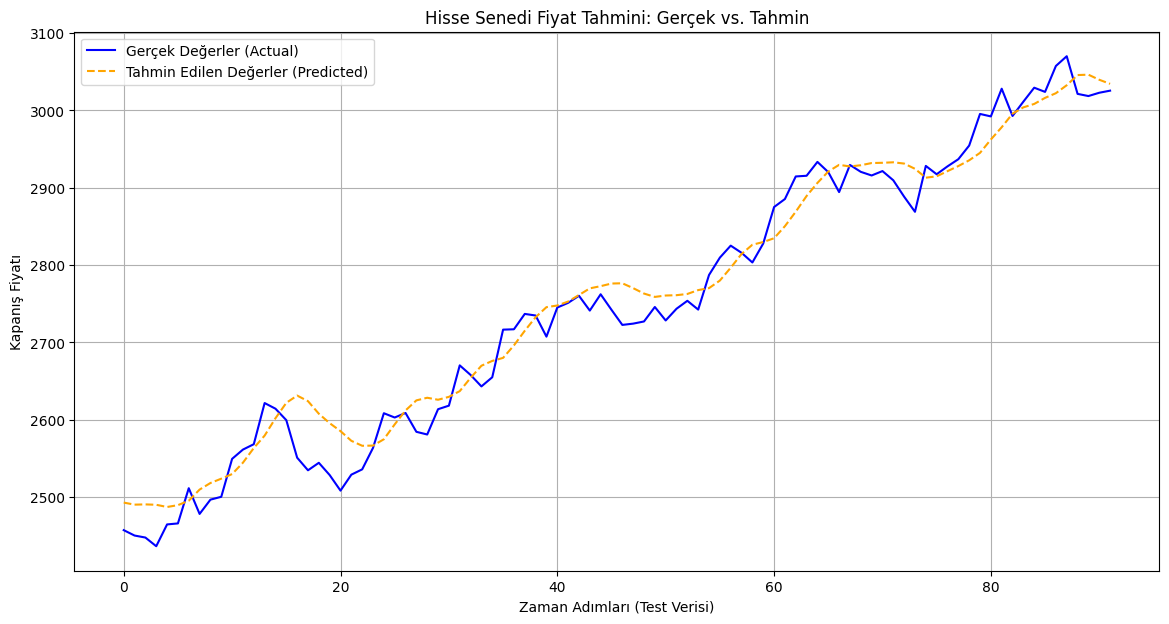

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# --- Test Kodu ---

# 1. Modeli Değerlendirme Moduna Alma
# Bu, Dropout veya BatchNorm gibi katmanları devre dışı bırakır. Test sırasında gereklidir.
model.eval()

# Değerlendirme sırasında gradyan hesaplamasına ihtiyacımız yok. Bu, işlemleri hızlandırır.
with torch.no_grad():
    all_predictions = []
    all_actuals = []
    
    # Test DataLoader'ı üzerindeki tüm batch'leri döngüye alıyoruz.
    for batch_x, batch_y in test_loader:
        # Model ile tahmin yapıyoruz.
        test_pred = model(batch_x)
        
        # Tahminleri ve gerçek değerleri daha sonra kullanmak üzere listelere ekliyoruz.
        # .numpy() ile tensörleri NumPy dizisine çeviriyoruz.
        all_predictions.append(test_pred.numpy())
        all_actuals.append(batch_y.numpy())

# Listelerdeki tüm batch sonuçlarını tek bir büyük NumPy dizisinde birleştiriyoruz.
all_predictions = np.concatenate(all_predictions, axis=0)
all_actuals = np.concatenate(all_actuals, axis=0)

# 2. Sonuçları Orijinal Ölçeğe Geri Döndürme
# Model, 0-1 arasına ölçeklenmiş verilerle eğitildiği için tahminleri de bu ölçekte yapar.
# Sonuçları anlamlı kılmak için (örneğin gerçek fiyat değerlerini görmek için) 
# hem tahminleri hem de gerçek değerleri orijinal ölçeklerine geri çevirmeliyiz.
predictions_original_scale = scaler.inverse_transform(all_predictions)
actuals_original_scale = scaler.inverse_transform(all_actuals)

# 3. Performans Metriğini Hesaplama
# Kök Ortalama Kare Hatası (RMSE - Root Mean Squared Error)
# Bu metrik, tahminlerin gerçek değerlerden ortalamada ne kadar saptığını gösterir.
# Değeri ne kadar düşükse, model o kadar iyidir.
rmse = np.sqrt(mean_squared_error(actuals_original_scale, predictions_original_scale))
print(f"\nTest Verisi Üzerindeki Kök Ortalama Kare Hatası (RMSE): {rmse:.4f}")


# 4. Sonuçları Görselleştirme
# Tahminlerin gerçek değerlere ne kadar yakın olduğunu görmek için en iyi yoldur.
plt.figure(figsize=(14, 7))
plt.plot(actuals_original_scale, label='Gerçek Değerler (Actual)', color='blue')
plt.plot(predictions_original_scale, label='Tahmin Edilen Değerler (Predicted)', color='orange', linestyle='--')
plt.title('Hisse Senedi Fiyat Tahmini: Gerçek vs. Tahmin')
plt.xlabel('Zaman Adımları (Test Verisi)')
plt.ylabel('Kapanış Fiyatı')
plt.legend()
plt.grid(True)
plt.show()